# Non-Normality of Financial Returns (MSFT)

This notebook demonstrates why daily stock returns are typically **not normally distributed**, using Microsoft (MSFT) as an example.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def _to_1d_array(values):
    array = np.asarray(values, dtype=float).ravel()
    return array[np.isfinite(array)]

def normal_pdf(x, loc=0.0, scale=1.0):
    if scale <= 0:
        raise ValueError("scale must be positive.")
    x = np.asarray(x, dtype=float)
    z = (x - loc) / scale
    return np.exp(-0.5 * z**2) / (scale * np.sqrt(2.0 * np.pi))

def compute_skewness(values):
    array = _to_1d_array(values)
    if array.size < 3:
        return np.nan
    mean = array.mean()
    std = array.std(ddof=0)
    if std == 0:
        return 0.0
    return np.mean(((array - mean) / std) ** 3)

def compute_excess_kurtosis(values):
    array = _to_1d_array(values)
    if array.size < 4:
        return np.nan
    mean = array.mean()
    std = array.std(ddof=0)
    if std == 0:
        return -3.0
    kurtosis = np.mean(((array - mean) / std) ** 4)
    return kurtosis - 3.0

def normality_test(values):
    # Jarque-Bera style normality test with chi-square(2) tail p-value.
    array = _to_1d_array(values)
    if array.size < 8:
        return np.nan, np.nan
    skewness_value = compute_skewness(array)
    excess_kurtosis_value = compute_excess_kurtosis(array)
    statistic = (array.size / 6.0) * (skewness_value**2 + 0.25 * excess_kurtosis_value**2)
    p_value = np.exp(-0.5 * statistic)
    return statistic, p_value

pd.options.display.float_format = '{:,.6f}'.format
plt.style.use('seaborn-v0_8-darkgrid')

## 1) Load MSFT Price Data

In [9]:
CSV_PATH = "msft.csv"  # Update this path if needed

price_data = pd.read_csv(CSV_PATH)

if "Date" not in price_data.columns:
    raise ValueError("CSV must contain a 'Date' column.")

price_data["Date"] = pd.to_datetime(price_data["Date"], errors="coerce")
price_data = price_data.dropna(subset=["Date"]).sort_values("Date").set_index("Date")

if "Adj Close" in price_data.columns:
    price_column = "Adj Close"
elif "Close" in price_data.columns:
    price_column = "Close"
elif "MSFT" in price_data.columns:
    price_column = "MSFT"
else:
    raise ValueError("CSV must contain either 'Adj Close' or 'Close'.")

price_series = pd.to_numeric(price_data[price_column], errors="coerce").dropna()

if price_series.empty:
    raise ValueError("No valid price data found after cleaning.")

print(f"Using price column: {price_column}")
print(f"Date range: {price_series.index.min().date()} to {price_series.index.max().date()}")
print(f"Price observations: {len(price_series)}")

price_series.head()

Using price column: MSFT
Date range: 2014-10-01 to 2021-05-28
Price observations: 1677


Date
2014-10-01   38.880161
2014-10-02   38.761574
2014-10-03   39.041103
2014-10-06   39.041103
2014-10-07   38.566746
Name: MSFT, dtype: float64

## 2) Compute Simple Returns and Log Returns

In [10]:
simple_returns = price_series.pct_change()
log_returns = np.log(price_series / price_series.shift(1))

returns_data = pd.DataFrame({
    "Simple Return": simple_returns,
    "Log Return": log_returns
}).dropna()

simple_returns = returns_data["Simple Return"]
log_returns = returns_data["Log Return"]

returns_data.head()

,Simple Return,Log Return
Date,,
2014-10-02,-0.003050,-0.003055
2014-10-03,0.007212,0.007186
2014-10-06,0.000000,0.000000
2014-10-07,-0.012150,-0.012225
2014-10-08,0.027455,0.027085


## 3) Summary Statistics for Log Returns

In [11]:
summary_statistics = log_returns.describe(percentiles=[0.01, 0.05, 0.50, 0.95, 0.99])
summary_statistics = summary_statistics.loc[["count", "mean", "std", "min", "1%", "5%", "50%", "95%", "99%", "max"]]

print("Summary Statistics (Log Returns):")
print(summary_statistics.to_string())

Summary Statistics (Log Returns):
count   1,676.000000
mean        0.001088
std         0.017233
min        -0.159454
1%         -0.044942
5%         -0.026242
50%         0.000961
95%         0.024306
99%         0.052284
max         0.132929


## 4) Histogram of Log Returns with Fitted Normal PDF

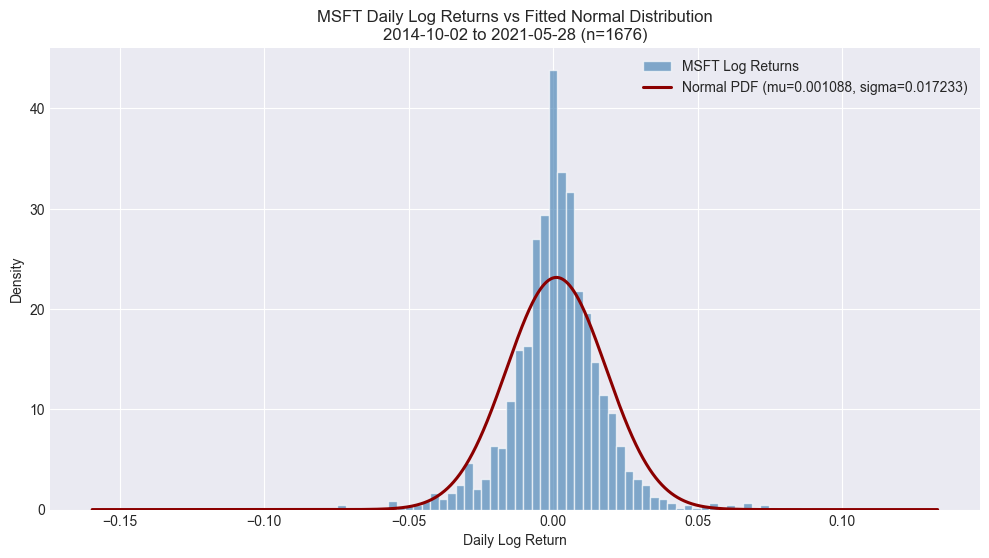

In [12]:
mu = log_returns.mean()
sigma = log_returns.std(ddof=1)

if sigma <= 0:
    raise ValueError("Standard deviation must be positive to fit a normal distribution.")

x = np.linspace(log_returns.min(), log_returns.max(), 10_000)
y = normal_pdf(x, loc=mu, scale=sigma)

start_date = log_returns.index.min().date()
end_date = log_returns.index.max().date()
sample_size = len(log_returns)

plt.figure(figsize=(12, 6))
plt.hist(log_returns, bins=100, density=True, alpha=0.65, color="steelblue", edgecolor="white", label="MSFT Log Returns")
plt.plot(x, y, color="darkred", linewidth=2.2, label=f"Normal PDF (mu={mu:.6f}, sigma={sigma:.6f})")
plt.title(f"MSFT Daily Log Returns vs Fitted Normal Distribution\n{start_date} to {end_date} (n={sample_size})")
plt.xlabel("Daily Log Return")
plt.ylabel("Density")
plt.legend()
plt.show()

## 5) Skewness and Excess Kurtosis

- **Skewness** indicates asymmetry of the return distribution.
  - Near 0: roughly symmetric
  - Positive: longer/right tail
  - Negative: longer/left tail
- **Excess kurtosis** indicates tail heaviness relative to normal.
  - Near 0: similar to normal
  - Positive: fatter tails (more extreme outcomes)
  - Negative: thinner tails

In [13]:
skewness = compute_skewness(log_returns)
excess_kurtosis = compute_excess_kurtosis(log_returns)

print(f"Skewness: {skewness:.6f}")
print(f"Excess Kurtosis (Fisher): {excess_kurtosis:.6f}")

Skewness: -0.207317
Excess Kurtosis (Fisher): 10.781875


## 6) Normality Test (NumPy-Based Jarque-Bera)

How to interpret the p-value:
- **Null hypothesis (H0):** returns are normally distributed.
- **Alternative hypothesis (H1):** returns are not normally distributed.
- The **p-value** is the probability of observing a result at least this extreme if H0 were true.

Rule of thumb at a 5% significance level:
- If **p < 0.05**, evidence is strong enough to **reject H0** (normality is unlikely).
- If **p >= 0.05**, there is **not enough evidence to reject H0**.

Important: **p >= 0.05 does not prove normality**. It only means this test did not find strong enough evidence against normality for this sample.

In [15]:
normality_statistic, normality_p_value = normality_test(log_returns)

print(f"Normality Test Statistic: {normality_statistic:.6f}")
print(f"p-value: {normality_p_value:.6g}")

if normality_p_value < 0.05:
    print("Interpretation: p < 0.05, so we reject normality for this MSFT sample.")
else:
    print("Interpretation: p >= 0.05, so we do not reject normality for this MSFT sample.")

Normality Test Statistic: 8130.048677
p-value: 0
Interpretation: p < 0.05, so we reject normality for this MSFT sample.


## Final Conclusion

For this MSFT sample, daily returns are not well described by a normal distribution:
- Return tails are heavier than normal (positive excess kurtosis / fat tails).
- Mean and standard deviation alone can underestimate true tail risk.
- The normality test rejects normality when p-value is below 0.05.